In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, log_loss, roc_auc_score, confusion_matrix,
                             roc_curve)
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import zipfile
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
import torch.nn.functional as F
from utils.metrics_utils import display_metrics, plot_confusion_matrix, plot_roc_curve 

In [6]:
train_raw = pd.read_csv('data/quora_train.csv.zip', index_col=0).dropna(subset=["question1", "question2"])
test_raw  = pd.read_csv('data/quora_test.csv.zip', index_col=0).dropna(subset=["question1", "question2"])

In [7]:
train_raw = train_raw.dropna(subset=['question1','question2'])
test_raw = test_raw.dropna(subset=['question1','question2'])

In [8]:
train_df, val_df = train_test_split(
    train_raw,
    test_size=0.15,                      
    stratify=train_raw["is_duplicate"],
    random_state=42,
)

In [9]:
print(f"Train: {len(train_df)}  Val: {len(val_df)}  Test: {len(test_raw)}")

Train: 274914  Val: 48515  Test: 80858


In [10]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# Initialize BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.to(device)
bert_model.eval() # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [12]:
def get_bert_embedding(text, max_length=128):
    """Extract BERT embeddings for a given text."""
    # Tokenize and prepare input
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length,
                      truncation=True, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get BERT embeddings
    with torch.no_grad():
        outputs = bert_model(**inputs)
        # Use [CLS] token embedding as sentence representation
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    
    return embeddings[0]  # Return the embedding as a 1D array

# Function to compute BERT embeddings for question pairs
def get_question_pair_features(row):
    """Create feature vector for a pair of questions using BERT embeddings."""
    # Get embeddings for both questions
    emb1 = get_bert_embedding(row['question1'])
    emb2 = get_bert_embedding(row['question2'])
    
    # Create feature vector (concatenation, absolute difference, and element-wise product)
    concat = np.concatenate([emb1, emb2])
    diff = np.abs(emb1 - emb2)
    prod = emb1 * emb2
    
    return np.concatenate([concat, diff, prod])

In [14]:
# Extract BERT features
print('Extracting BERT features for training set...')
X_train = np.stack(train_df.apply(get_question_pair_features, axis=1).values)
y_train = train_df['is_duplicate'].values

print('Extracting BERT features for validation set...')
X_val = np.stack(val_df.apply(get_question_pair_features, axis=1).values)
y_val = val_df['is_duplicate'].values

print('Extracting BERT features for test set...')
X_test = np.stack(test_raw.apply(get_question_pair_features, axis=1).values)
y_test = test_raw['is_duplicate'].values

print(f'Feature dimension: {X_train.shape[1]}')

Extracting BERT features for training set...
Extracting BERT features for validation set...
Extracting BERT features for test set...
Feature dimension: 3072


In [16]:
class BERTBasedClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_classes=2, dropout=0.2):
        super(BERTBasedClassifier, self).__init__()
        
        self.net = nn.Sequential(
            # First layer
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Second layer with reduced dimensions
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Third layer with further reduction
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            # Output layer
            nn.Linear(hidden_dim // 4, num_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Epoch 1:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 01 | Train loss 0.4731 | Val acc 0.7891 | Val F1 0.7387


Epoch 2:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 02 | Train loss 0.4284 | Val acc 0.7998 | Val F1 0.7552


Epoch 3:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 03 | Train loss 0.4007 | Val acc 0.8060 | Val F1 0.7617


Epoch 4:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 04 | Train loss 0.3775 | Val acc 0.8115 | Val F1 0.7680


Epoch 5:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 05 | Train loss 0.3581 | Val acc 0.7986 | Val F1 0.7657


Epoch 6:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 06 | Train loss 0.3416 | Val acc 0.8155 | Val F1 0.7743


Epoch 7:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 07 | Train loss 0.3256 | Val acc 0.7990 | Val F1 0.7673


Epoch 8:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 08 | Train loss 0.3139 | Val acc 0.8248 | Val F1 0.7747


Epoch 9:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 09 | Train loss 0.3029 | Val acc 0.8164 | Val F1 0.7771


Epoch 10:   0%|          | 0/4296 [00:00<?, ?it/s]

Epoch 10 | Train loss 0.2936 | Val acc 0.8190 | Val F1 0.7756


C:\Users\Galyna\AppData\Local\Temp\ipykernel_8976\3464766611.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("bert_best_model.pt"))



Train-set results
Accuracy : 0.8858
Precision: 0.7827
Recall   : 0.9562
F1 Score : 0.8608
Log-Loss : 0.2583
ROC AUC  : 0.9650


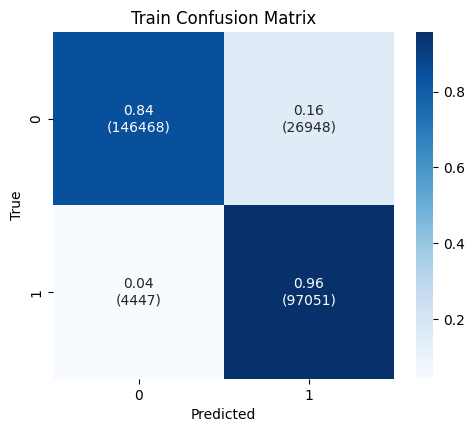

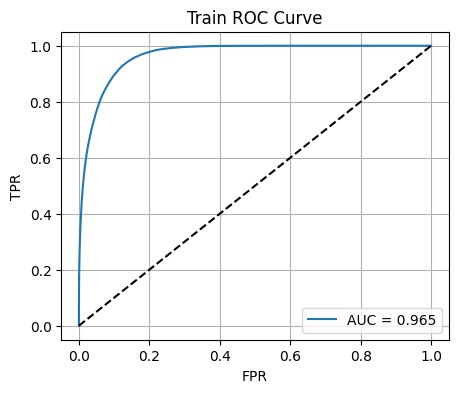


Validation-set results
Accuracy : 0.8164
Precision: 0.7043
Recall   : 0.8667
F1 Score : 0.7771
Log-Loss : 0.3910
ROC AUC  : 0.9082


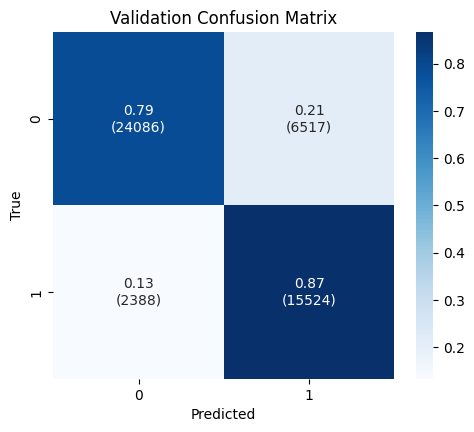

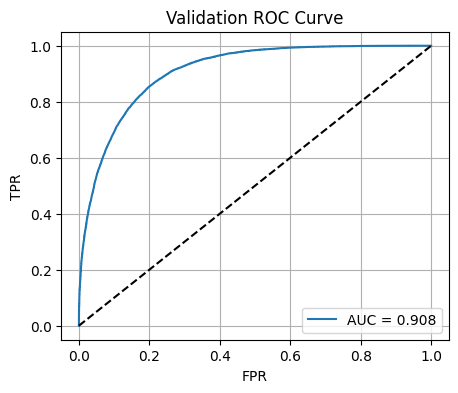


Test-set results
Accuracy : 0.8187
Precision: 0.7077
Recall   : 0.8670
F1 Score : 0.7793
Log-Loss : 0.3880
ROC AUC  : 0.9090


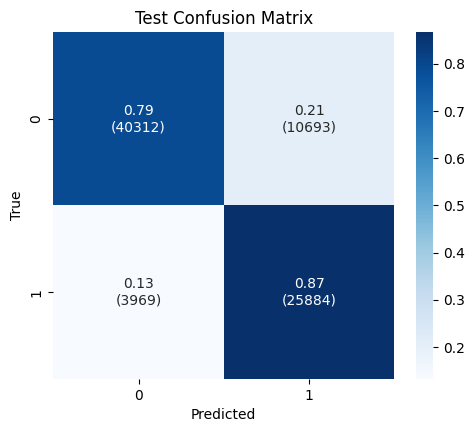

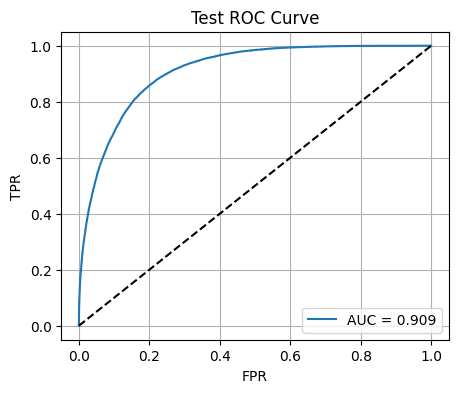

In [19]:
# Calculate class weights to handle imbalance
class_counts  = np.bincount(y_train)
class_weights = torch.tensor(len(y_train) / (class_counts * len(class_counts)),
                             dtype=torch.float32).to(device)

# Initialize model
model = BERTBasedClassifier(input_dim=X_train.shape[1], hidden_dim=512, dropout=0.2).to(device)

# Use weighted CrossEntropyLoss to handle class imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use AdamW optimizer with weight decay
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.01) 

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                 factor=0.5, patience=2, verbose=True)

# Training parameters
num_epochs = 10
best_val_f1 = 0.0
patience = 5  # for early stopping
no_improve = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    
    for Xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item() * Xb.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    
    # Validation
    val_true, val_pred, val_prob = predict_on_loader(model, val_loader, device)
    val_acc = accuracy_score(val_true, val_pred)
    val_f1  = f1_score     (val_true, val_pred)
    scheduler.step(val_f1)

    print(f"Epoch {epoch:02} | Train loss {train_loss:.4f} | "
          f"Val acc {val_acc:.4f} | Val F1 {val_f1:.4f}")
    
    # Save best model and handle early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "bert_embeddings_model.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

# Load best model and evaluate on all sets
model.load_state_dict(torch.load("bert_embeddings_model.pt"))

for name, loader in [("Train", train_loader),
                     ("Validation", val_loader),
                     ("Test",  test_loader)]:
    y_true, y_pred, y_prob = predict_on_loader(model, loader, device)
    print(f"\n{name}-set results")
    display_metrics(y_true, y_pred, y_prob)
    plot_confusion_matrix(y_true, y_pred, labels=["0", "1"],
                          title=f"{name} Confusion Matrix")
    plot_roc_curve(y_true, y_prob, title=f"{name} ROC Curve")